# 0. Libraries

In [39]:
# loading dataset, plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing dataset (converting timestamp to numerical)
from datetime import datetime
from dateutil.parser import parse

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense 

# 1. Reading dataset

In [40]:
# loading csv dataset

# Local
# dataset_path = "dataset/psi_df_2016_2019.csv"

# using Google Drive
dataset_path = "/content/drive/My Drive/Work/YapAiTek/Assessment/dataset/psi_df_2016_2019.csv"
df = pd.read_csv(dataset_path)

In [41]:
df.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00


# 2. Preprocessing Dataset

adding year, month, day and hour to dataset

In [42]:
df['year'] = [row[1]['timestamp'][:4] for row in df.iterrows()]
df['month'] = [row[1]['timestamp'][5:7] for row in df.iterrows()]
df['day'] = [row[1]['timestamp'][8:10] for row in df.iterrows()]
df['hour'] = [row[1]['timestamp'][11:13] for row in df.iterrows()]

converting timestamp to numerical timestamp

In [43]:
timestamp = df['timestamp'].values
numerical_timestamp = []

# parsing string timestamp for each row
for i in timestamp:
  tp = parse(i).timestamp()
  dt = datetime.fromtimestamp(tp)
  numerical_timestamp.append(dt)

# dropping string timestamp from dataframe
df = df.drop('timestamp', 1)

# adding numerical timestamp to dataframe
df['timestamp'] = numerical_timestamp

In [44]:
df.head()

,national,south,north,east,central,west,year,month,day,hour,timestamp
0,47,44,37,47,47,34,2016,02,07,18,2016-02-07 10:00:00
1,59,57,54,59,57,56,2016,02,08,23,2016-02-08 15:00:00
2,59,57,55,59,57,56,2016,02,09,01,2016-02-08 17:00:00
3,59,57,55,59,56,56,2016,02,09,02,2016-02-08 18:00:00
4,59,58,55,59,56,56,2016,02,09,03,2016-02-08 19:00:00


Checking dataset for NaN values

In [45]:
df.isnull().values.any()

False

Setting Timestamps as index of dataframe

In [46]:
df = df.set_index('timestamp')

In [47]:
df.head()

,national,south,north,east,central,west,year,month,day,hour
timestamp,,,,,,,,,,
2016-02-07 10:00:00,47,44,37,47,47,34,2016,02,07,18
2016-02-08 15:00:00,59,57,54,59,57,56,2016,02,08,23
2016-02-08 17:00:00,59,57,55,59,57,56,2016,02,09,01
2016-02-08 18:00:00,59,57,55,59,56,56,2016,02,09,02
2016-02-08 19:00:00,59,58,55,59,56,56,2016,02,09,03


# 3. Plotting Data

plotting y vs x

In [48]:
y_labels = ['national', 'south', 'north', 'east', 'central', 'west']
y = [df['national'], df['south'], df['north'], df['east'], df['central'], df['west']]

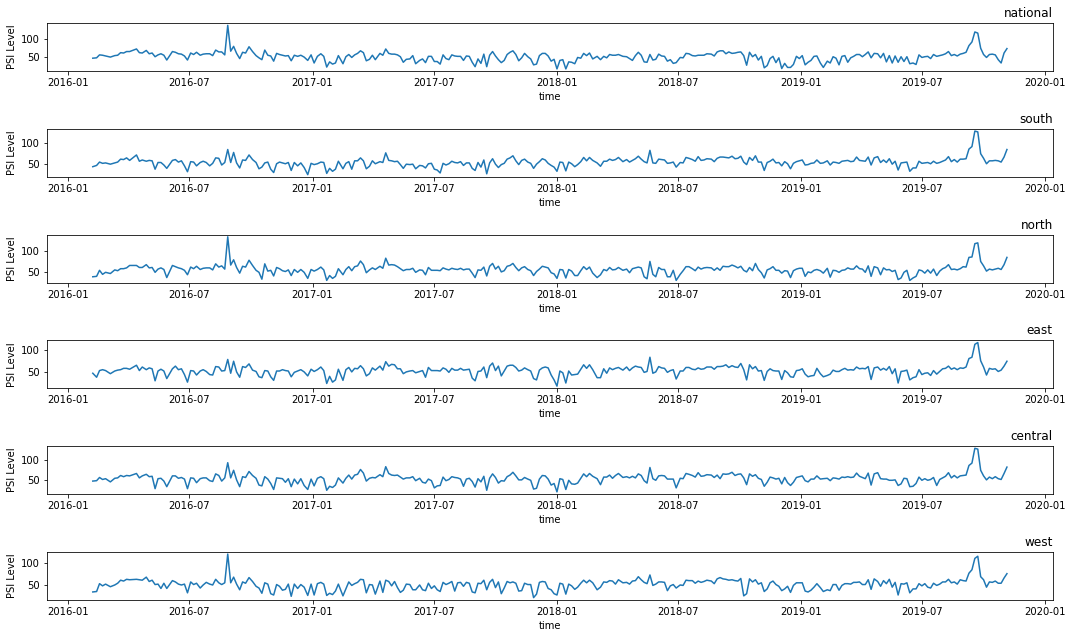

In [49]:
# plot each column
plt.figure(figsize=(15,10))
suplot_idx = 1

for i in range(6):
  fig = plt.subplot(7, 1, suplot_idx)
  plt.tight_layout()
  plt.plot(y[i][::100])
  plt.title(y_labels[i], y=0.5, loc='right')

  # set xlabel and ylabel
  plt.xlabel("time")
  plt.ylabel("PSI Level")

  suplot_idx += 1

plotting histogram

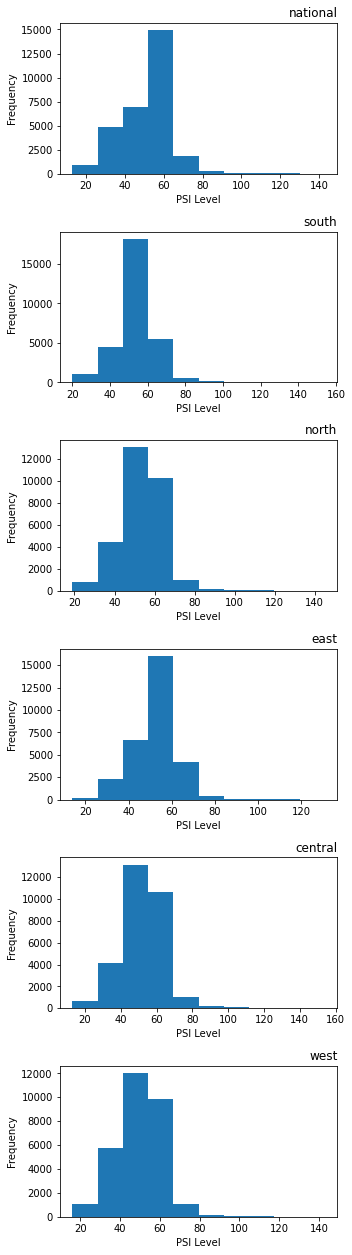

In [50]:
# plot each column
plt.figure(figsize=(5,20))
suplot_idx = 1

for i in range(6):
  fig = plt.subplot(7, 1, suplot_idx)
  plt.tight_layout()
  plt.hist(y[i])
  plt.title(y_labels[i], y=0.5, loc='right')

  # set xlabel and ylabel
  plt.xlabel("PSI Level")
  plt.ylabel("Frequency")

  suplot_idx += 1

In [51]:
df.describe()

,national,south,north,east,central,west
count,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000
mean,50.502232,54.294351,54.003464,52.491007,52.885884,50.299014
std,13.107219,10.844489,10.991413,10.365553,11.832203,11.672157
min,13.000000,20.000000,19.000000,14.000000,13.000000,16.000000
25%,42.000000,50.000000,49.000000,47.000000,47.000000,43.000000
50%,53.000000,54.000000,55.000000,54.000000,54.000000,52.000000
75%,58.000000,59.000000,59.000000,58.000000,59.000000,57.000000
max,143.000000,154.000000,145.000000,131.000000,154.000000,143.000000


# 4. Preparing data for LSTM

Converting Series to a Supervised dataset

In [52]:
# using year, month, day, hour and 4 shifts of data
# x_national = df.loc[:, 'year':'hour']

columns = ['national', 'south', 'north', 'east', 'central', 'west']

for c, c_name in enumerate(columns):
  for i in range(1, 5):
    column_name = c_name + '_+' + str(i) 
    df[column_name] = df[c_name].shift(i)

The first 4 rows have NaNs because there is no available data before them. So. we drop them

In [53]:
df.dropna(inplace=True)

Scaling data to range (-1, 1)

In [54]:
# converting all cells to float 
df = df.apply(pd.to_numeric)

# normalizing data
df = (df - df.mean()) / (df.max() - df.min())

In [55]:
df.head()

,national,south,north,east,central,west,year,month,day,hour,national_+1,national_+2,national_+3,national_+4,south_+1,south_+2,south_+3,south_+4,north_+1,north_+2,north_+3,north_+4,east_+1,east_+2,east_+3,east_+4,central_+1,central_+2,central_+3,central_+4,west_+1,west_+2,west_+3,west_+4
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-08 19:00:00,0.065373,0.027654,0.007905,0.055636,0.022087,0.04489,-0.501954,-0.411829,-0.226127,-0.407643,0.065377,0.065381,0.065385,-0.026916,0.020196,0.020201,0.020206,-0.076800,0.00791,0.007914,-0.000018,-0.134930,0.055640,0.055644,0.055648,-0.046908,0.022092,0.029190,0.029194,-0.041721,0.044894,0.044898,0.044902,-0.128317
2016-02-08 20:00:00,0.065373,0.027654,0.007905,0.055636,0.022087,0.04489,-0.501954,-0.411829,-0.226127,-0.362189,0.065377,0.065381,0.065385,0.065392,0.027659,0.020201,0.020206,0.020214,0.00791,0.007914,0.007919,-0.000009,0.055640,0.055644,0.055648,0.055656,0.022092,0.022097,0.029194,0.029201,0.044894,0.044898,0.044902,0.044911
2016-02-08 21:00:00,0.065373,0.027654,0.007905,0.055636,0.029179,0.04489,-0.501954,-0.411829,-0.226127,-0.316734,0.065377,0.065381,0.065385,0.065392,0.027659,0.027664,0.020206,0.020214,0.00791,0.007914,0.007919,0.007928,0.055640,0.055644,0.055648,0.055656,0.022092,0.022097,0.022102,0.029201,0.044894,0.044898,0.044902,0.044911
2016-02-08 22:00:00,0.073065,0.027654,0.007905,0.064183,0.029179,0.04489,-0.501954,-0.411829,-0.226127,-0.271280,0.065377,0.065381,0.065385,0.065392,0.027659,0.027664,0.027669,0.020214,0.00791,0.007914,0.007919,0.007928,0.055640,0.055644,0.055648,0.055656,0.029185,0.022097,0.022102,0.022109,0.044894,0.044898,0.044902,0.044911
2016-02-08 23:00:00,0.073065,0.027654,0.015842,0.064183,0.029179,0.04489,-0.501954,-0.411829,-0.226127,-0.225825,0.073069,0.065381,0.065385,0.065392,0.027659,0.027664,0.027669,0.027677,0.00791,0.007914,0.007919,0.007928,0.064187,0.055644,0.055648,0.055656,0.029185,0.029190,0.022102,0.022109,0.044894,0.044898,0.044902,0.044911


# 5. Training

In [56]:
def select_data(df, column_name):
  """
  Selects related features for a regression task
  Ex:
    For column_name = national
    Selects:
      year, month, day, hour
      national_+1, national_+2, national_+3, national_+4
  """
  
  # using year, month, day, hour and 4 shifts of data
  x_column = df.loc[:, 'year':'hour']
  first_index = column_name + '_+1'
  last_index = column_name + '_+4'
  x_column = pd.concat( [x_column, df.loc[:, first_index:last_index] ] , axis=1, sort=False)
  y_column = df[column_name]

  # splitting dataset for train and test
  X_train = x_column[:25000].values
  y_train = y_column[:25000].values
  X_test = x_column[25000:].values
  y_test = y_column[25000:].values

  # reshaping x, y
  X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], 1) )
  y_train = y_train.reshape( (len(y_train), 1) )
  X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], 1) ) 
  y_test = y_test.reshape( (len(y_test), 1) )

  return X_train, y_train, X_test, y_test

In [57]:
def create_and_train_model(X_train, y_train, X_test, y_test):
  """
  Creates an LSTM-based model
  Compiles it
  Trains it on training data and validates it on validation data
  Draws Loss chart
  
  Returns Model
  """

  # creating model
  model = Sequential()
  model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], 1) ))
  model.add(Dense(1))

  # compiling model
  model.compile(loss="mse", optimizer="adam")

  # fitting model on train data
  history = model.fit(X_train, y_train, epochs=10, batch_size=64, 
                    validation_data=(X_test, y_test), shuffle=False)
  
  # plot loss chart
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  plt.ylabel('MSE Loss')
  plt.ylim([0, 0.003])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


  # plot predictions
  index = [x for x in range(5018)]
  true_value = y_test
  predicted_value = model.predict(X_test)
  plt.figure(figsize=(20,15))
  plt.plot(index, true_value, marker=".", label="true value")
  plt.plot(index, predicted_value, label="predicted value")
  plt.title('Test data (true vs predicted)')
  plt.xlabel("time")
  plt.ylabel("PSI level")
  plt.legend(loc='upper right')


  return model

## 5.1. National

In [58]:
X_train, y_train, X_test, y_test = select_data(df, 'national')

In [59]:
print(f"x_national_train shape: \t {X_train.shape}")
print(f"y_national_train shape: \t {y_train.shape}")
print(f"x_national_test shape: \t\t {X_test.shape}")
print(f"y_national_test shape: \t\t {y_test.shape}")

x_national_train shape: 	 (25000, 8, 1)
y_national_train shape: 	 (25000, 1)
x_national_test shape: 		 (5018, 8, 1)
y_national_test shape: 		 (5018, 1)


Epoch 1/10
391/391 [==============================] - 3s 8ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 5.1674e-04 - val_loss: 5.4284e-04
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 4.4890e-04 - val_loss: 4.6689e-04
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 4.3626e-04 - val_loss: 4.3607e-04
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 4.3017e-04 - val_loss: 4.2851e-04
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 4.2628e-04 - val_loss: 4.2268e-04
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 4.2148e-04 - val_loss: 4.1986e-04
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 4.1723e-04 - val_loss: 4.1445e-04
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 4.1213e-04 - val_loss: 4.1434e-04
Epoch 10/10
391/391 [===============

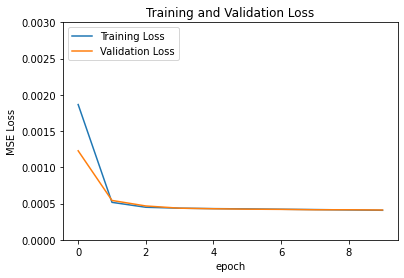

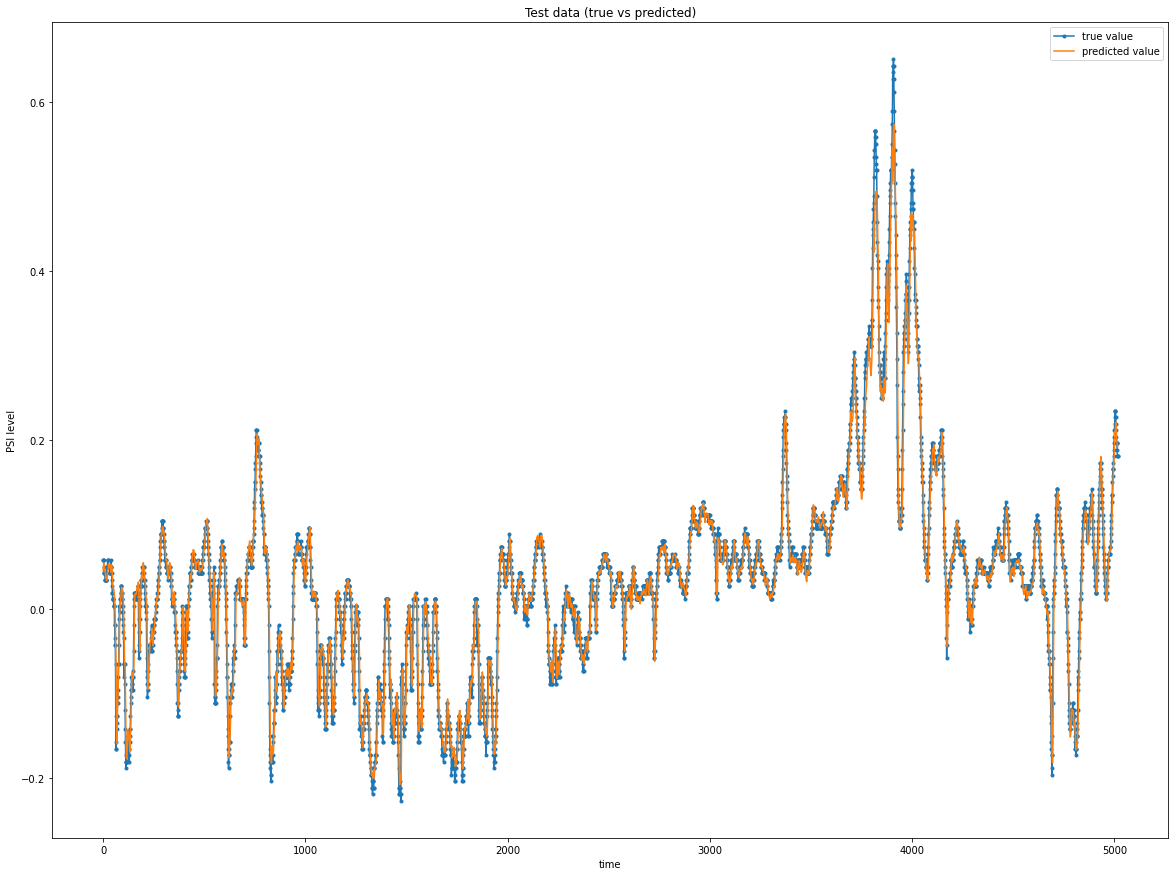

In [60]:
national_model = create_and_train_model(X_train, y_train, X_test, y_test)

In [61]:
national_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## 5.2. South

Epoch 1/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 3.8961e-04 - val_loss: 4.3936e-04
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 2.9976e-04 - val_loss: 3.6825e-04
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 2.9247e-04 - val_loss: 3.4955e-04
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 2.8937e-04 - val_loss: 3.4794e-04
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 2.8692e-04 - val_loss: 3.5073e-04
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 2.8442e-04 - val_loss: 3.5957e-04
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 2.8171e-04 - val_loss: 3.6863e-04
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 2.7861e-04 - val_loss: 3.7840e-04
Epoch 10/10
391/391 [===============

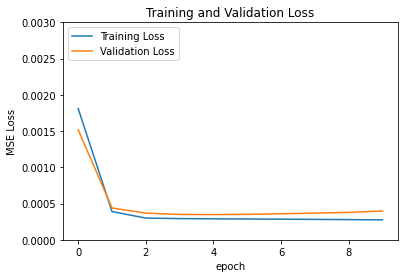

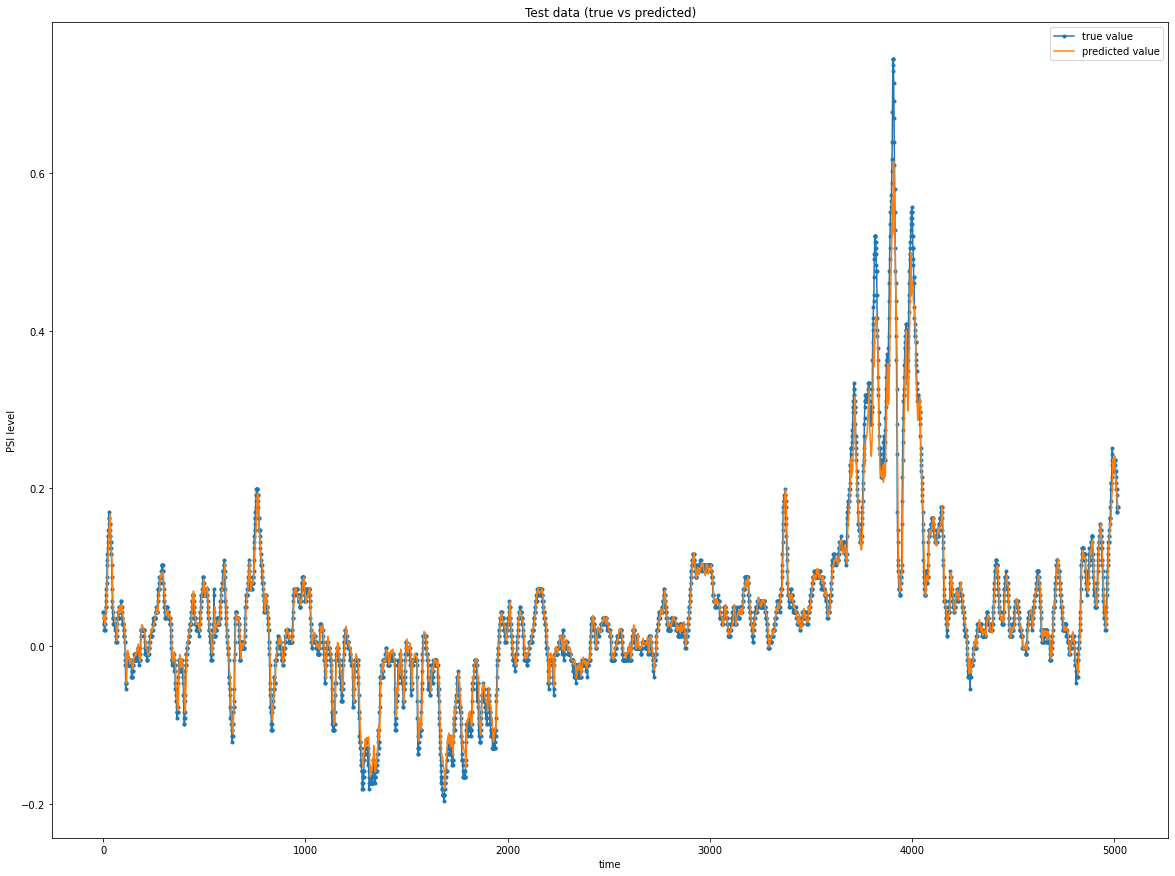

In [62]:
X_train, y_train, X_test, y_test = select_data(df, 'south')
south_model = create_and_train_model(X_train, y_train, X_test, y_test)

## 5.3. North

Epoch 1/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 6.3688e-04 - val_loss: 7.4350e-04
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 4.3900e-04 - val_loss: 5.0715e-04
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 3.9777e-04 - val_loss: 4.4323e-04
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 3.8599e-04 - val_loss: 4.2203e-04
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 3.8050e-04 - val_loss: 4.1324e-04
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 3.7713e-04 - val_loss: 4.0568e-04
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 3.7300e-04 - val_loss: 4.0195e-04
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 3.6950e-04 - val_loss: 3.9908e-04
Epoch 10/10
391/391 [===============

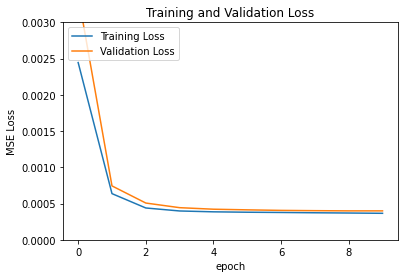

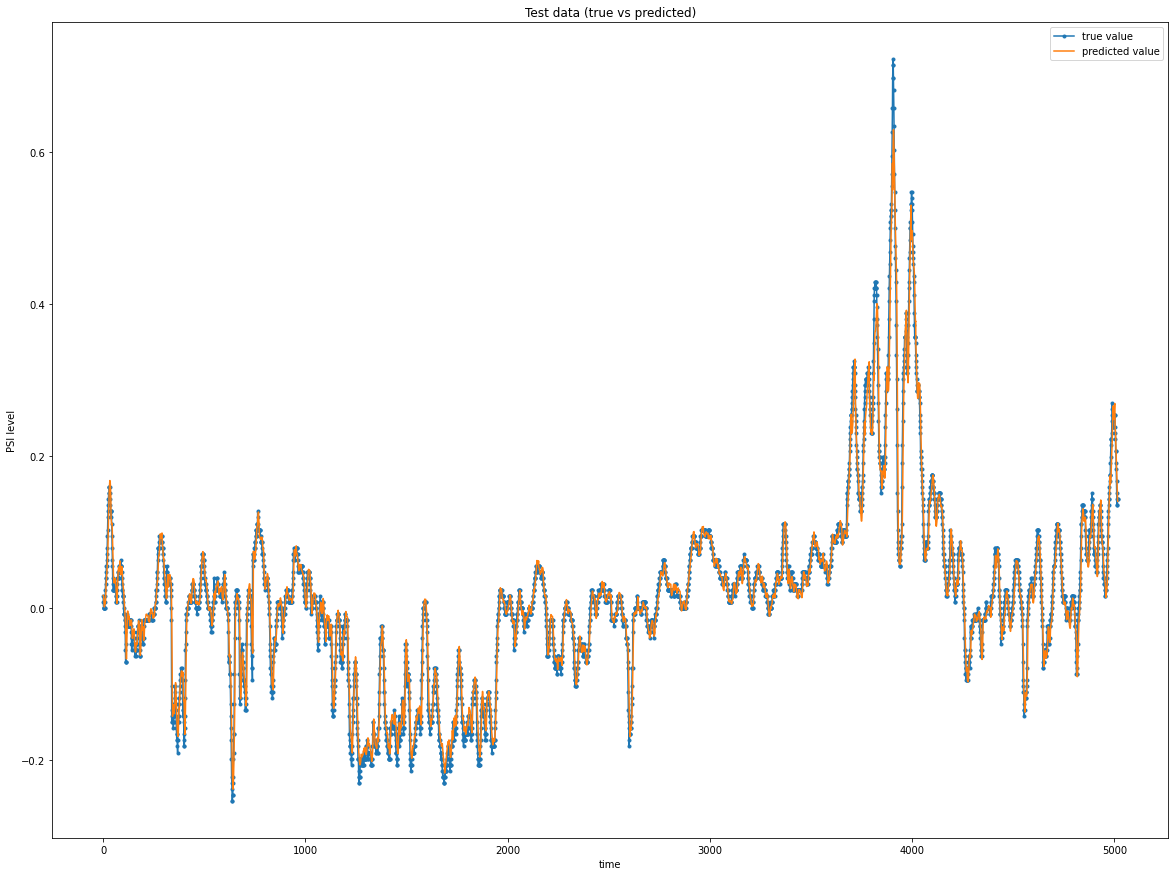

In [63]:
X_train, y_train, X_test, y_test = select_data(df, 'north')
north_model = create_and_train_model(X_train, y_train, X_test, y_test)

## 5.4. East

Epoch 1/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 4.5925e-04 - val_loss: 8.6308e-04
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 4.3309e-04 - val_loss: 6.9868e-04
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 4.2534e-04 - val_loss: 6.1620e-04
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 4.2116e-04 - val_loss: 5.7955e-04
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 4.1621e-04 - val_loss: 5.6243e-04
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 4.1067e-04 - val_loss: 5.4560e-04
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 4.0407e-04 - val_loss: 5.3515e-04
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 3.9596e-04 - val_loss: 5.2772e-04
Epoch 10/10
391/391 [===============

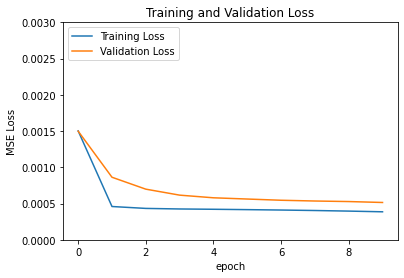

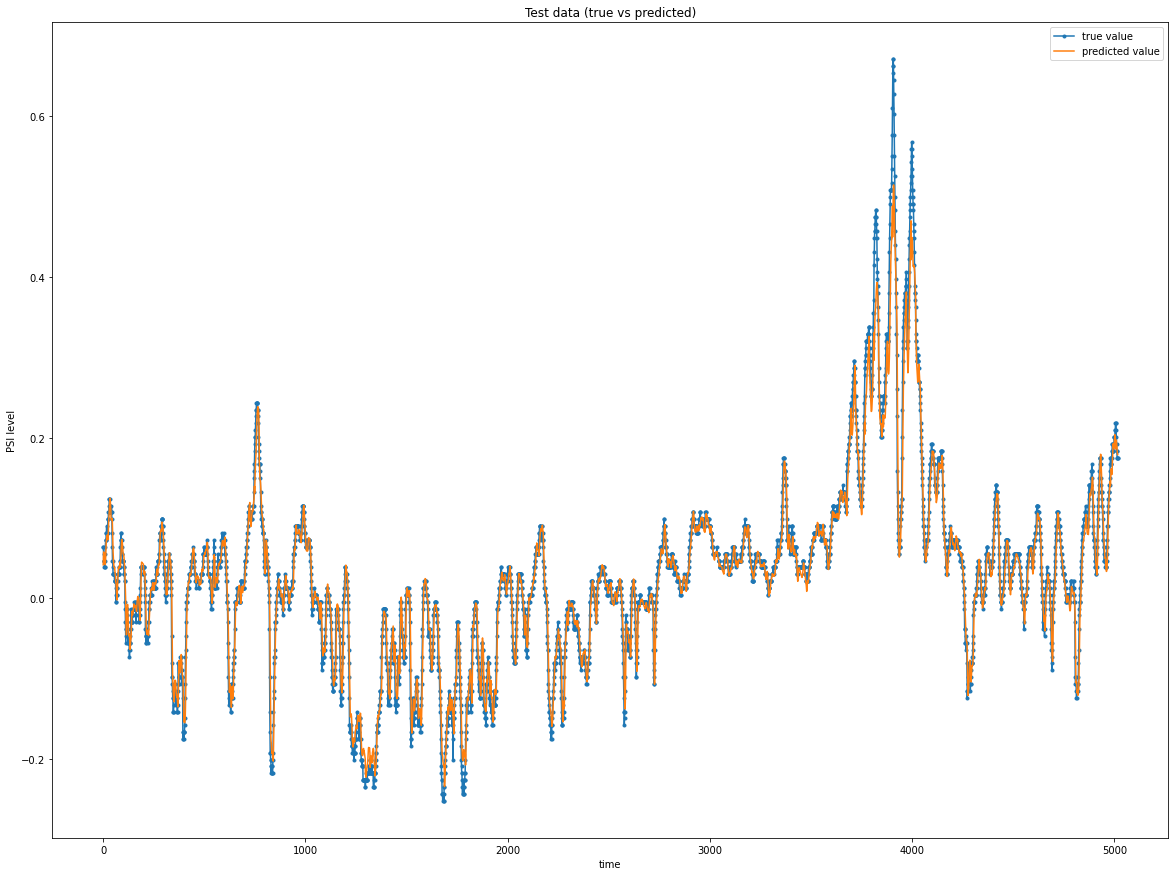

In [64]:
X_train, y_train, X_test, y_test = select_data(df, 'east')
east_model = create_and_train_model(X_train, y_train, X_test, y_test)

## 5.5. Central

Epoch 1/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 3.8814e-04 - val_loss: 5.6617e-04
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 3.4136e-04 - val_loss: 4.6709e-04
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 3.3596e-04 - val_loss: 4.3613e-04
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 3.3279e-04 - val_loss: 4.3076e-04
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 3.3014e-04 - val_loss: 4.3308e-04
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 3.2700e-04 - val_loss: 4.3441e-04
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 3.2311e-04 - val_loss: 4.3431e-04
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 3.1897e-04 - val_loss: 4.3259e-04
Epoch 10/10
391/391 [===============

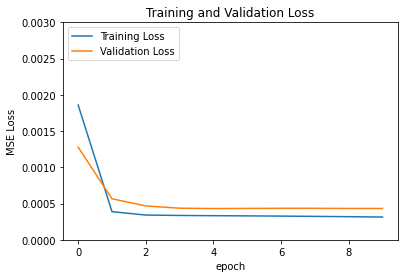

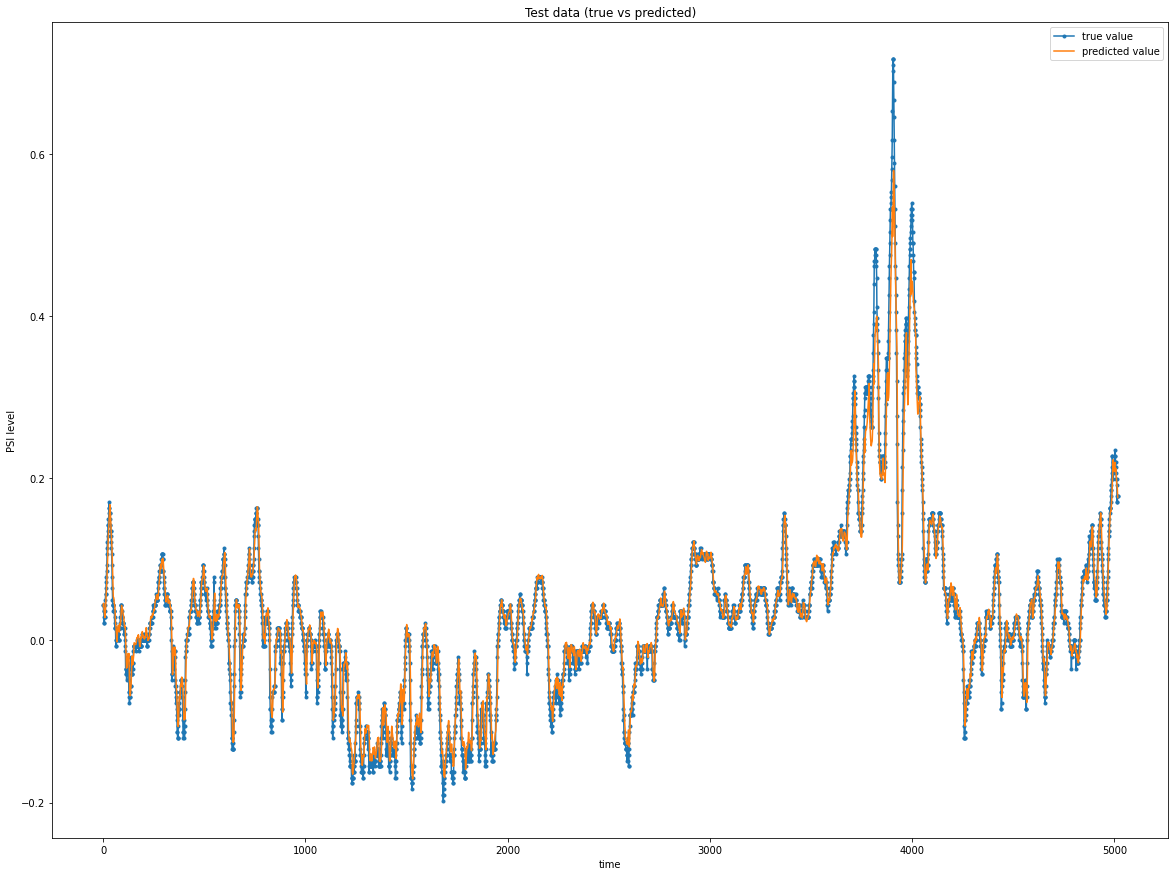

In [65]:
X_train, y_train, X_test, y_test = select_data(df, 'central')
central_model = create_and_train_model(X_train, y_train, X_test, y_test)

## 5.6. West

Epoch 1/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 5.7060e-04 - val_loss: 4.1448e-04
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 4.5606e-04 - val_loss: 3.7917e-04
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 4.4839e-04 - val_loss: 3.6568e-04
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 4.4508e-04 - val_loss: 3.5943e-04
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 4.4196e-04 - val_loss: 3.5911e-04
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 4.3834e-04 - val_loss: 3.6095e-04
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 4.3414e-04 - val_loss: 3.6113e-04
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 4.2912e-04 - val_loss: 3.5968e-04
Epoch 10/10
391/391 [===============

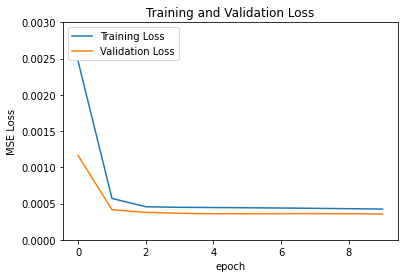

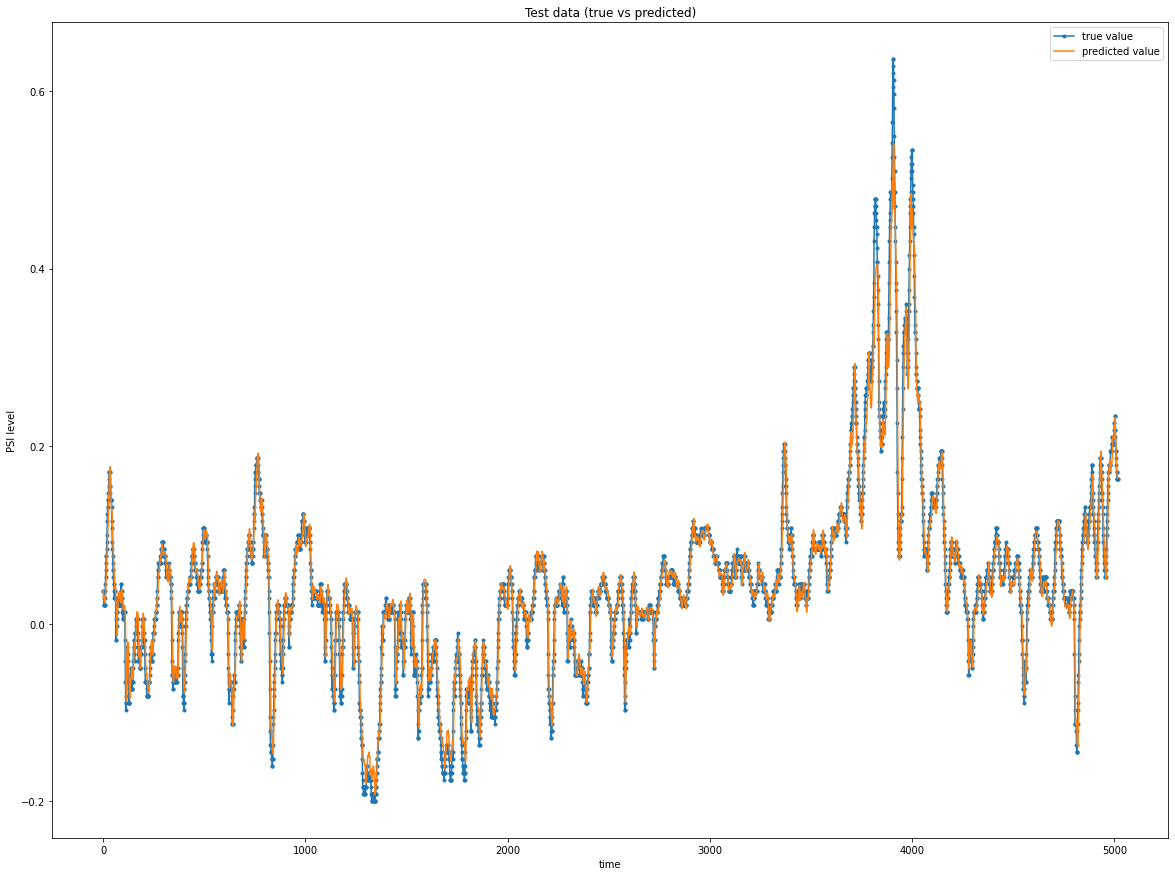

In [66]:
X_train, y_train, X_test, y_test = select_data(df, 'west')
west_model = create_and_train_model(X_train, y_train, X_test, y_test)

We observe that our model follows the data very well. Only around data number 4000 - which there is great and sudden changes - our model cannot follow the data.